In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import fdopen, remove, walk
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [3]:
from datetime import date

In [4]:
DATASET_PATH = "/Users/noopy/covid19_unknown_spread/dataset"

In [5]:
# get oldest file in the dataset folder
import os, heapq
def newst_files_in_tree(rootfolder, count=1, extension=".csv"):
    return heapq.nlargest(count,
        (os.path.join(dirname, filename)
        for dirname, dirnames, filenames in os.walk(rootfolder)
        for filename in filenames
        if filename.endswith(extension)),
        key=lambda fn: os.stat(fn).st_mtime)

In [6]:
newst_csv = newst_files_in_tree(DATASET_PATH)[0]

In [7]:
df_temp = pd.read_csv(newst_csv, encoding="utf-8")
df_temp.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
1017,4317,21209,9.05.,양천구,키르기즈스탄,해외 접촉 추정,퇴원
3492,1842,15258,8.15.,도봉구,-,성북구 사랑제일교회 관련,퇴원
504,4830,22624,9.16.,송파구,-,기타 확진자 접촉,NaN
3291,2043,15351,8.16.,성북구,-,성북구 사랑제일교회 관련,퇴원
4354,980,11785,6.06.,성동구,-,이태원 클럽 관련,퇴원
3719,1615,14422,8.3.,강서구,-,강서구 확진자 접촉,퇴원
5013,321,8836,3.21.,영등포구,독일,해외 접촉 추정,퇴원
96,5238,23675,9.28.,성북구,-,기타 확진자 접촉,NaN
535,4799,22566,9.16.,동작구,-,기타 확진자 접촉,퇴원
5265,69,1907,2.25.,노원구,-,확인중,퇴원


In [58]:
# overwrite whatever cell value that contains "확인" as "확인 중"
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"] = "확인 중"

df_temp.loc[df_temp["접촉력"].str.contains("조사 중"),"접촉력"] = "확인 중"

# check whether those two arrays are combined
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"].unique()

array([&#39;확인 중&#39;], dtype=object)

In [59]:
df_temp["접촉력"] = df_temp["접촉력"].str.replace("관련", "")
df_temp["접촉력"] = df_temp["접촉력"].str.strip()

In [60]:
infection_paths = df_temp["접촉력"].unique()
print(len(infection_paths))
infection_paths

260


array([&#39;확인 중&#39;, &#39;해외 접촉 추정&#39;, &#39;강남구 삼성화재&#39;, &#39;기타 확진자 접촉&#39;, &#39;서초구 LG 유플러스&#39;,
       &#39;고양시부부(마포구어린이집&amp;서초구우체국)&#39;, &#39;마포구 고등학교&#39;, &#39;타시도 확진자 접촉&#39;, &#39;도봉구 다나병원&#39;,
       &#39;관악구가족&#39;, &#39;관악구 식당&#39;, &#39;양천구 양천경찰서&#39;, &#39;도봉구 예마루데이케어센터&#39;, &#39;강남구 소재 대우디오빌플러스&#39;,
       &#39;관악구 삼모스포렉스&#39;, &#39;신도림 역사&#39;, &#39;강남구 디와이디벨로먼트&#39;, &#39;동대문구 성경모임&#39;, &#39;송파구 우리교회&#39;,
       &#39;중랑구 서울의료원&#39;, &#39;종로구 서울대병원&#39;, &#39;관악구 사랑나무 어린이집&#39;, &#39;성동구 덕수고 야구부&#39;,
       &#39;프로그래머 지인모임&#39;, &#39;강남구 신도벤처타워&#39;, &#39;영등포구 LG트윈타워&#39;, &#39;강남구 K보건산업&#39;, &#39;건축설명회&#39;,
       &#39;종로구청&#39;, &#39;강남구 통신판매업&#39;, &#39;도봉구 소재 아파트&#39;, &#39;관악구 지인모임&#39;, &#39;영등포 소재 증권회사&#39;,
       &#39;서대문구 세브란스병원&#39;, &#39;영등포구 소재 마트&#39;, &#39;강남구 소재 금융회사&#39;, &#39;동작구 요양시설&#39;,
       &#39;9월 송파구 지인모임&#39;, &#39;은평구 수색성당&#39;, &#39;서울지방국세청&#39;, &#39;수도권 지인모임&#39;, &#39;서대문구 지인모임&#39;,
       &#39;영등포 지인모임&#39;, &#39;관악구 에

In [61]:
df_date = df_temp.sort_values(["연번"], ascending=False)
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5334,23946,10.01.,구로구,-,확인 중,NaN
1,5333,23917,10.01.,성북구,-,확인 중,NaN
2,5332,23916,10.01.,종로구,인도네시아,해외 접촉 추정,NaN
3,5331,23947,10.01.,성동구,-,강남구 삼성화재,NaN
4,5330,23937,10.01.,관악구,-,기타 확진자 접촉,NaN


In [62]:
df_date["확진일"] = df_date["확진일"].str.replace(".", "-")
df_date["확진일"] = df_date["확진일"].str[:-1]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5334,23946,10-01,구로구,-,확인 중,NaN
1,5333,23917,10-01,성북구,-,확인 중,NaN
2,5332,23916,10-01,종로구,인도네시아,해외 접촉 추정,NaN
3,5331,23947,10-01,성동구,-,강남구 삼성화재,NaN
4,5330,23937,10-01,관악구,-,기타 확진자 접촉,NaN


In [63]:
df_date["확진일"] = "2020-0" + df_date["확진일"]
df_date["확진일"] = df_date["확진일"].str.replace("010","10")
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5334,23946,2020-10-01,구로구,-,확인 중,NaN
1,5333,23917,2020-10-01,성북구,-,확인 중,NaN
2,5332,23916,2020-10-01,종로구,인도네시아,해외 접촉 추정,NaN
3,5331,23947,2020-10-01,성동구,-,강남구 삼성화재,NaN
4,5330,23937,2020-10-01,관악구,-,기타 확진자 접촉,NaN


In [64]:
df_date.sample(5)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
308,5026,23182,2020-09-22,관악구,-,관악구 삼모스포렉스,NaN
4475,859,11448,2020-05-30,영등포구,-,연아나뉴스클래스,퇴원
448,4886,22744,2020-09-17,관악구,-,관악구 지인모임,NaN
1427,3907,19989,2020-08-30,금천구,-,타시도 확진자 접촉,퇴원
2603,2731,16962,2020-08-21,종로구,-,성북구 사랑제일교회,퇴원


In [65]:
df = df_date.copy()
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5334,23946,2020-10-01,구로구,-,확인 중,NaN
1,5333,23917,2020-10-01,성북구,-,확인 중,NaN
2,5332,23916,2020-10-01,종로구,인도네시아,해외 접촉 추정,NaN
3,5331,23947,2020-10-01,성동구,-,강남구 삼성화재,NaN
4,5330,23937,2020-10-01,관악구,-,기타 확진자 접촉,NaN


In [66]:
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-0", "-")
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-", "-0")
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5334,23946,2020-10-01,구로구,-,확인 중,NaN
1,5333,23917,2020-10-01,성북구,-,확인 중,NaN
2,5332,23916,2020-10-01,종로구,인도네시아,해외 접촉 추정,NaN
3,5331,23947,2020-10-01,성동구,-,강남구 삼성화재,NaN
4,5330,23937,2020-10-01,관악구,-,기타 확진자 접촉,NaN


In [67]:
df.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
1760,3574,19146,2020-08-28,서대문구,-,8.15서울도심집회,퇴원
4590,744,11103,2020-05-19,용산구,파키스탄,해외 접촉 추정,퇴원
3361,1973,15299,2020-08-15,강동구,-,성북구 사랑제일교회,퇴원
867,4467,21559,2020-09-08,광진구,-,영등포구 일련정종 서울포교소,퇴원
2314,3020,17604,2020-08-24,노원구,-,노원구 빛가온교회,퇴원
2678,2656,16856,2020-08-21,양천구,-,기타 확진자 접촉,퇴원
4971,363,9301,2020-03-26,금천구,-,구로구 교회,퇴원
991,4343,21234,2020-09-06,관악구,-,확인 중,퇴원
2767,2567,16511,2020-08-20,양천구,-,8.15서울도심집회,퇴원
4007,1327,12904,2020-07-01,관악구,-,관악구 일가족,퇴원


In [68]:
df.to_csv("./dataset_predict/df_wrangle.csv", index=False)

In [69]:
temp = df["확진일"].value_counts().rename_axis('date').reset_index(name='new_confirmed')
temp.head()

,date,new_confirmed
0,2020-08-29,167
1,2020-08-27,160
2,2020-08-26,157
3,2020-08-18,151
4,2020-08-15,146


In [70]:
df_predict = temp.sort_values(by="date")
df_predict.head()

,date,new_confirmed
219,2020-01-24,1
190,2020-01-30,3
195,2020-01-31,3
221,2020-02-02,1
202,2020-02-05,2


### stretch the dataframe as timeseries dataset with interval of 1 day 

In [71]:
df_predict["date"] = pd.to_datetime(df_predict["date"])

In [72]:
df_predict.index = pd.DatetimeIndex(df_predict["date"])
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1
2020-01-30,2020-01-30,3
2020-01-31,2020-01-31,3
2020-02-02,2020-02-02,1
2020-02-05,2020-02-05,2


In [73]:
df_predict = df_predict.resample('D').max()
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,NaT,NaN
2020-01-26,NaT,NaN
2020-01-27,NaT,NaN
2020-01-28,NaT,NaN


In [74]:
df_predict["date"] = df_predict.index
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,NaN
2020-01-26,2020-01-26,NaN
2020-01-27,2020-01-27,NaN
2020-01-28,2020-01-28,NaN


In [75]:
df_predict = df_predict.fillna(0)
df_predict[:10]

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,0.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0
2020-01-29,2020-01-29,0.0
2020-01-30,2020-01-30,3.0
2020-01-31,2020-01-31,3.0
2020-02-01,2020-02-01,0.0


In [76]:
df_predict.to_csv("dataset_predict/df_predict.csv", index=False)

In [77]:
df_predict =  pd.read_csv("dataset_predict/df_predict.csv", encoding="utf-8")

### get untracked patients information

In [78]:
df_untracked = df[df["접촉력"]=="확인 중"]
df_untracked

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5334,23946,2020-10-01,구로구,-,확인 중,NaN
1,5333,23917,2020-10-01,성북구,-,확인 중,NaN
5,5329,23912,2020-10-01,관악구,-,확인 중,NaN
15,5319,23869,2020-09-30,강동구,-,확인 중,NaN
24,5310,23864,2020-09-30,관악구,-,확인 중,NaN
...,...,...,...,...,...,...,...
5278,56,1768,2020-02-25,고양시,-,확인 중,퇴원
5292,42,1370,2020-02-25,노원구,-,확인 중,퇴원
5295,39,924,2020-02-25,평택,-,확인 중,퇴원
5296,38,907,2020-02-25,관악구,-,확인 중,퇴원


In [79]:
df_untracked_temp = df_untracked.groupby(by=["확진일"]).size()
df_untracked_temp = df_untracked_temp.rename_axis('date').reset_index(name='new_untracked')
df_untracked_temp

,date,new_untracked
0,2020-02-25,6
1,2020-02-26,1
2,2020-02-27,2
3,2020-02-28,2
4,2020-03-02,2
...,...,...
146,2020-09-27,2
147,2020-09-28,9
148,2020-09-29,4
149,2020-09-30,6


In [80]:
df_untracked_no = df_untracked_temp

In [81]:
df_merged = pd.merge(df_predict, df_untracked_no, how="left", on="date")
df_merged = df_merged.fillna(0)
df_merged.head(15)

,date,new_confirmed,new_untracked
0,2020-01-24,1.0,0.0
1,2020-01-25,0.0,0.0
2,2020-01-26,0.0,0.0
3,2020-01-27,0.0,0.0
4,2020-01-28,0.0,0.0
5,2020-01-29,0.0,0.0
6,2020-01-30,3.0,0.0
7,2020-01-31,3.0,0.0
8,2020-02-01,0.0,0.0
9,2020-02-02,1.0,0.0


In [82]:
df_merged.tail(15)

,date,new_confirmed,new_untracked
237,2020-09-17,43.0,10.0
238,2020-09-18,40.0,6.0
239,2020-09-19,28.0,9.0
240,2020-09-20,23.0,4.0
241,2020-09-21,39.0,10.0
242,2020-09-22,40.0,8.0
243,2020-09-23,25.0,4.0
244,2020-09-24,54.0,7.0
245,2020-09-25,25.0,2.0
246,2020-09-26,35.0,8.0


In [83]:
list_infection_paths_no = []
for index, row in df_merged.iterrows():
    filter_end_date = row["date"]
    # print(filter_end_date)
    df_filtered = df.loc[df['확진일'] <= filter_end_date]
    
    # 확진자 접촉력이 밝혀진 경우
    infection_paths_known_no = len(df_filtered["접촉력"].unique())
    
    # "기타 확진자 접촉", "타시도 확진자 접촉" 항목 485건 / R0
    etc_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("기타 확진자 접촉")])/1.5
    state_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("타시도 확진자 접촉")])/1.5

    infection_paths_no = infection_paths_known_no + etc_contact_no + state_contact_no
    list_infection_paths_no.append(int(infection_paths_no))
print(list_infection_paths_no[:10])
print(list_infection_paths_no[-10:])

[1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
[839, 842, 852, 860, 865, 869, 878, 880, 889, 892]


In [84]:
df_merged["no_paths"] = list_infection_paths_no
df_merged["new_confirmed"] = df_merged["new_confirmed"].apply(int)
df_merged["new_untracked"] = df_merged["new_untracked"].apply(int)
df_merged.head()

,date,new_confirmed,new_untracked,no_paths
0,2020-01-24,1,0,1
1,2020-01-25,0,0,1
2,2020-01-26,0,0,1
3,2020-01-27,0,0,1
4,2020-01-28,0,0,1


In [85]:
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths
247,2020-09-27,18,2,869
248,2020-09-28,26,9,878
249,2020-09-29,36,4,880
250,2020-09-30,30,6,889
251,2020-10-01,11,3,892


In [86]:
df_merged["new_no_paths"] = df_merged["no_paths"].diff()
df_merged.tail(10)

,date,new_confirmed,new_untracked,no_paths,new_no_paths
242,2020-09-22,40,8,839,6.0
243,2020-09-23,25,4,842,3.0
244,2020-09-24,54,7,852,10.0
245,2020-09-25,25,2,860,8.0
246,2020-09-26,35,8,865,5.0
247,2020-09-27,18,2,869,4.0
248,2020-09-28,26,9,878,9.0
249,2020-09-29,36,4,880,2.0
250,2020-09-30,30,6,889,9.0
251,2020-10-01,11,3,892,3.0


In [87]:
df_merged = df_merged[["date", "new_confirmed", "new_untracked", "new_no_paths"]]

In [88]:
df_merged.to_csv("dataset_predict/df_predict.csv", index=False)

### Label holiday as column

In [89]:
import json

list_calendar=[]

calendar_file = "./korean-calendar/korean-calendar.json"
# read file
with open(calendar_file, 'r') as myfile:
    data=myfile.readlines()

data = [x.strip() for x in data] 

for i in data:
    calendar_data = i[43:]
    calendar_item = "{"+calendar_data
    calendar_item_json = json.loads(calendar_item)
    list_calendar.append(calendar_item_json)
list_calendar[:10]

[{&#39;sc&#39;: &#39;2000-01-01&#39;, &#39;lc&#39;: &#39;1999-11-25&#39;, &#39;w&#39;: 7, &#39;h&#39;: True, &#39;ht&#39;: &#39;신정&#39;},
 {&#39;sc&#39;: &#39;2000-01-02&#39;, &#39;lc&#39;: &#39;1999-11-26&#39;, &#39;w&#39;: 1, &#39;h&#39;: False, &#39;ht&#39;: &#39;&#39;},
 {&#39;sc&#39;: &#39;2000-01-03&#39;, &#39;lc&#39;: &#39;1999-11-27&#39;, &#39;w&#39;: 2, &#39;h&#39;: False, &#39;ht&#39;: &#39;&#39;},
 {&#39;sc&#39;: &#39;2000-01-04&#39;, &#39;lc&#39;: &#39;1999-11-28&#39;, &#39;w&#39;: 3, &#39;h&#39;: False, &#39;ht&#39;: &#39;&#39;},
 {&#39;sc&#39;: &#39;2000-01-05&#39;, &#39;lc&#39;: &#39;1999-11-29&#39;, &#39;w&#39;: 4, &#39;h&#39;: False, &#39;ht&#39;: &#39;&#39;},
 {&#39;sc&#39;: &#39;2000-01-06&#39;, &#39;lc&#39;: &#39;1999-11-30&#39;, &#39;w&#39;: 5, &#39;h&#39;: False, &#39;ht&#39;: &#39;&#39;},
 {&#39;sc&#39;: &#39;2000-01-07&#39;, &#39;lc&#39;: &#39;1999-12-01&#39;, &#39;w&#39;: 6, &#39;h&#39;: False, &#39;ht&#39;: &#39;&#39;},
 {&#39;sc&#39;: &#39;2000-01-08&#39;, &#

In [90]:
df_calendar = pd.DataFrame(list_calendar)
df_calendar = df_calendar[["sc", "w", "h"]]
df_calendar.head()

,sc,w,h
0,2000-01-01,7,True
1,2000-01-02,1,False
2,2000-01-03,2,False
3,2000-01-04,3,False
4,2000-01-05,4,False


In [91]:
# notate sunday, friday, saturday as weekend: which is 1
def label_weekend(row):
    # sunday
    if row['w'] == 1:
        return 1
    # friday
    if row['w'] == 6:
        return 1
    # saturday
    if row['w'] == 7:
        return 1
    else:
        return 0

In [92]:
df_calendar["is_weekend"] = df_calendar.apply(lambda row: label_weekend(row), axis=1)
df_calendar.head(10)

,sc,w,h,is_weekend
0,2000-01-01,7,True,1
1,2000-01-02,1,False,1
2,2000-01-03,2,False,0
3,2000-01-04,3,False,0
4,2000-01-05,4,False,0
5,2000-01-06,5,False,0
6,2000-01-07,6,False,1
7,2000-01-08,7,False,1
8,2000-01-09,1,False,1
9,2000-01-10,2,False,0


In [93]:
# rename dataframe name
df_calendar.rename(columns = {'sc':'date', 'h':'is_holiday'}, inplace = True)

In [94]:
# if it is holiday, notate as 1. If not, notate as 0
df_calendar.loc[df_calendar["is_holiday"]==True, "is_holiday"] = 1
df_calendar.loc[df_calendar["is_holiday"]==False, "is_holiday"] = 0
df_calendar[:10]

,date,w,is_holiday,is_weekend
0,2000-01-01,7,1,1
1,2000-01-02,1,0,1
2,2000-01-03,2,0,0
3,2000-01-04,3,0,0
4,2000-01-05,4,0,0
5,2000-01-06,5,0,0
6,2000-01-07,6,0,1
7,2000-01-08,7,0,1
8,2000-01-09,1,0,1
9,2000-01-10,2,0,0


In [95]:
df_calendar.to_csv("dataset_predict/df_calendar.csv", index=False)

In [96]:
df_calendar_subset = df_calendar[["date", "is_holiday", "is_weekend"]]

In [97]:
df_train = pd.merge(df_merged, df_calendar_subset, how="left", on="date")
df_train.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend
247,2020-09-27,18,2,4.0,0,1
248,2020-09-28,26,9,9.0,0,0
249,2020-09-29,36,4,2.0,0,0
250,2020-09-30,30,6,9.0,1,0
251,2020-10-01,11,3,3.0,1,0


### Add Government Social Distancing Policy

In [98]:
df_train["gov_policy"] = 0
df_train[-10:]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
242,2020-09-22,40,8,6.0,0,0,0
243,2020-09-23,25,4,3.0,0,0,0
244,2020-09-24,54,7,10.0,0,0,0
245,2020-09-25,25,2,8.0,0,1,0
246,2020-09-26,35,8,5.0,0,1,0
247,2020-09-27,18,2,4.0,0,1,0
248,2020-09-28,26,9,9.0,0,0,0
249,2020-09-29,36,4,2.0,0,0,0
250,2020-09-30,30,6,9.0,1,0,0
251,2020-10-01,11,3,3.0,1,0,0


In [99]:
# 서울의 사회적 거리두기 2단계는 8월 16일부터 조치됨
# 서울에는 8월 19일 0시 기준으로 새로운 조치들이 추가되며, 흔히 얘기하는 2.5단계가 됨. 이후에 기간 연장을 해서 9.7(월)0시 ~ 9.13(일)24시까지 2.5단계가 시행됨

df_train.loc[(df_train["date"]>="2020-08-16") & (df_train["date"]<="2020-08-18"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-08-19") & (df_train["date"]<="2020-09-13"),"gov_policy"] = 3
df_train.loc[(df_train["date"]>="2020-09-14"),"gov_policy"] = 2

In [100]:
df_train.to_csv("./dataset_predict/df_train.csv", index=False)

## EDA

In [101]:
df_train.corr()

,new_confirmed,new_untracked,new_no_paths,is_weekend,gov_policy
new_confirmed,1.000000,0.874853,0.873438,-0.027201,0.768675
new_untracked,0.874853,1.000000,0.919546,-0.049664,0.792510
new_no_paths,0.873438,0.919546,1.000000,0.007470,0.846532
is_weekend,-0.027201,-0.049664,0.007470,1.000000,-0.011259
gov_policy,0.768675,0.792510,0.846532,-0.011259,1.000000


&lt;AxesSubplot:&gt;

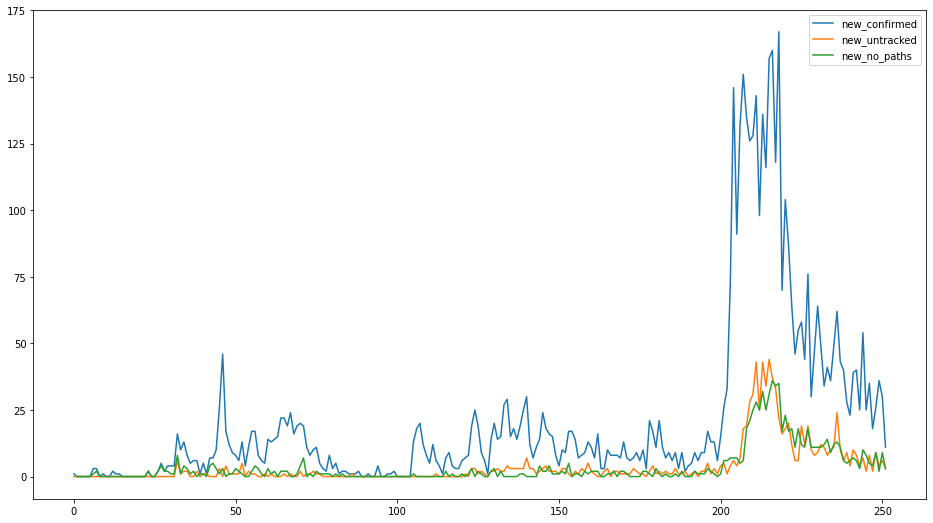

In [102]:
# 전체 그래프
df_train[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

&lt;AxesSubplot:&gt;

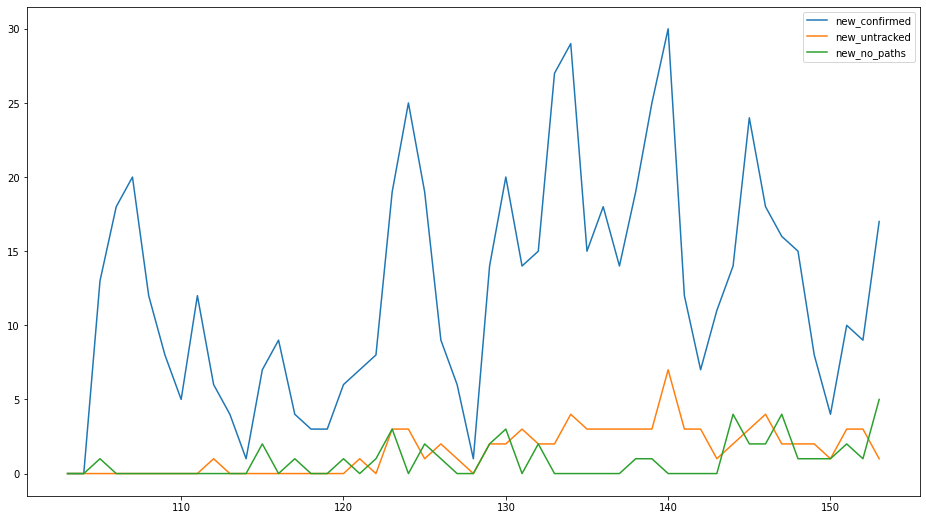

In [103]:
itaewon_crisis = df_train[(df_train["date"]>="2020-05-06") & (df_train["date"]<="2020-06-25")]
itaewon_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))


&lt;AxesSubplot:&gt;

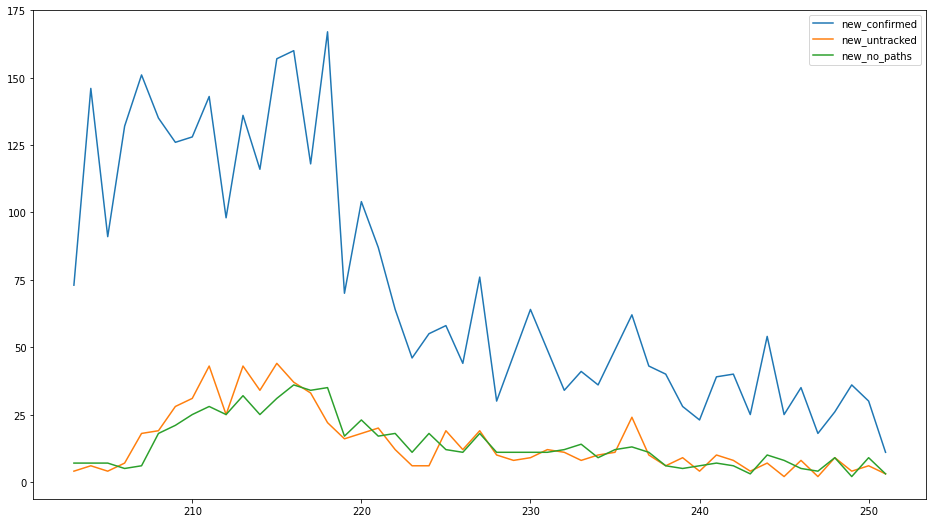

In [104]:
# 서울시 사랑제일교회 광복절 집회 이후의 데이터
jkh_crisis = df_train[(df_train["date"]>="2020-08-14")]
jkh_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

&lt;AxesSubplot:&gt;

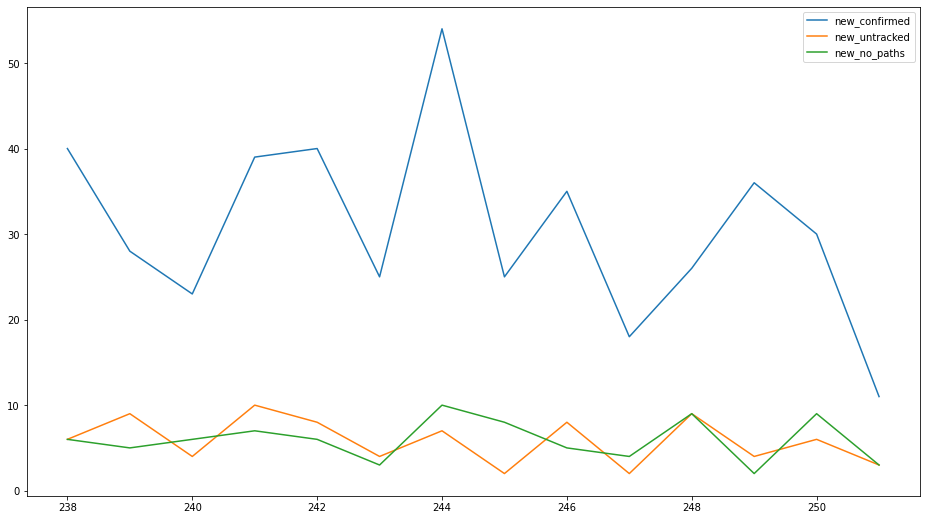

In [105]:
# 최근 2주 데이터
recent_two_weeks_data = df_train.tail(14)
recent_two_weeks_data[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

&lt;AxesSubplot:&gt;

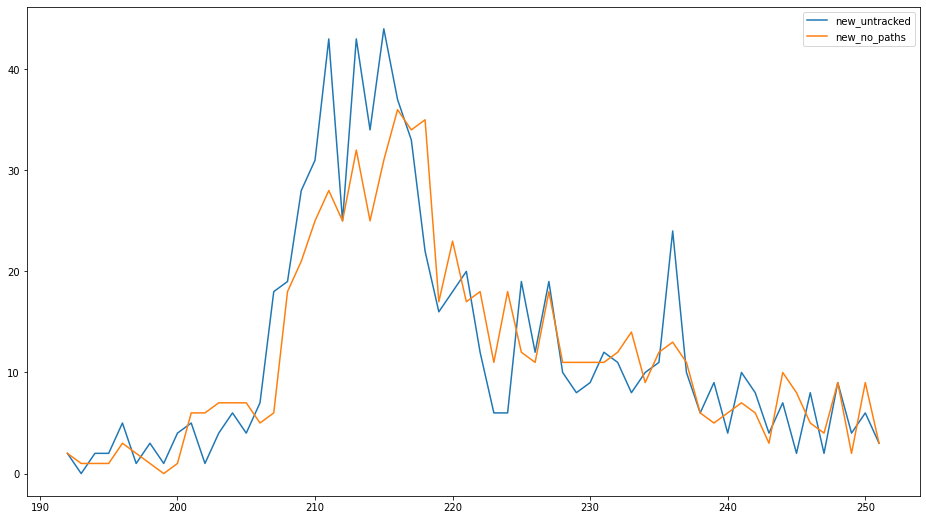

In [106]:
# 확인된 감염경로 개수와 경로 미확인 감염자 트렌드
unknown_and_paths_graph = df_train[["new_untracked", "new_no_paths"]][-60:].plot(figsize=(16,9))
unknown_and_paths_graph

In [107]:
fig = unknown_and_paths_graph.get_figure()
fig.savefig('./img/unknown_and_paths_graph.png')